In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

In [3]:
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [8]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
test_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [10]:
train_df.loc[:, ['Name', 'Ticket', 'Cabin']].nunique()

Name      891
Ticket    681
Cabin     147
dtype: int64

<AxesSubplot:xlabel='Survived', ylabel='count'>

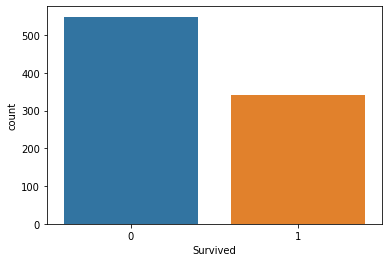

In [11]:
sns.countplot(x='Survived', data=train_df)

<AxesSubplot:xlabel='Sex', ylabel='count'>

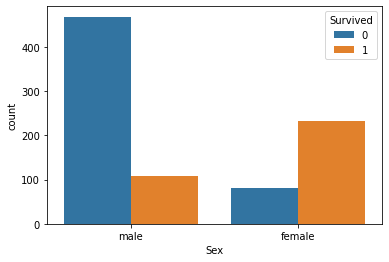

In [12]:
sns.countplot(x='Sex', hue='Survived', data=train_df)

<AxesSubplot:xlabel='Pclass', ylabel='count'>

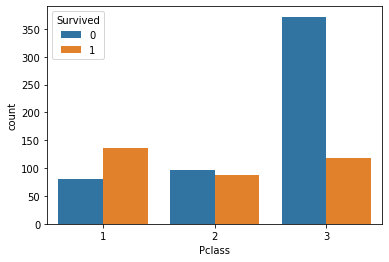

In [13]:
sns.countplot(x='Pclass', hue='Survived', data=train_df)

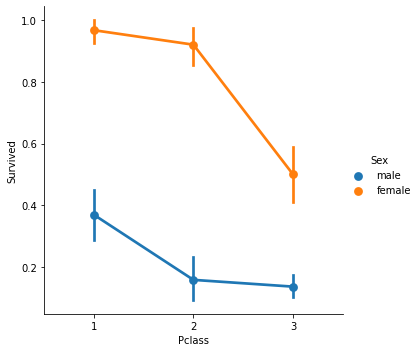

In [14]:
sns.catplot(x='Pclass', y='Survived', hue='Sex', data=train_df, kind='point')

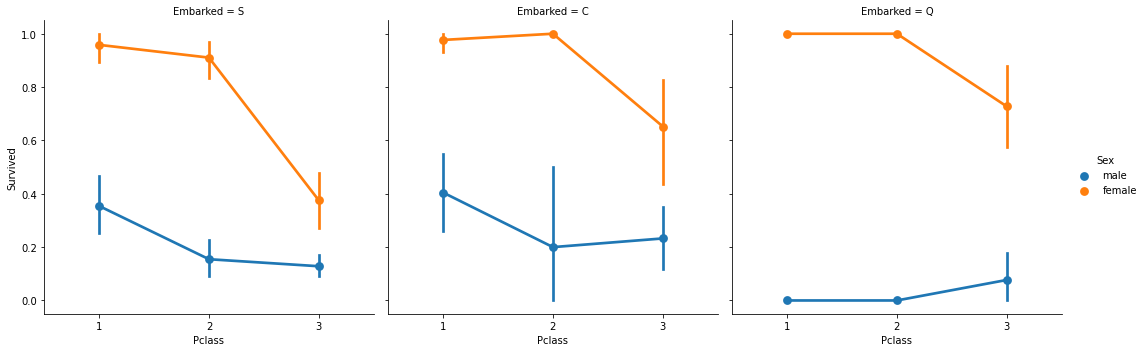

In [15]:
sns.catplot(x='Pclass', y='Survived', hue='Sex', col='Embarked', data=train_df, kind='point')

In [16]:
pass_id_train = train_df['PassengerId']
pass_id_test = test_df['PassengerId']
y_train = np.array(train_df['Survived'])

In [17]:
df = pd.concat([train_df, test_df], ignore_index = True, sort = False)

In [18]:
df[df['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [19]:
df[(df['Pclass']==1) & (df['Survived']==1)].groupby(by='Embarked')['Fare'].median()

Embarked
C    79.20
Q    90.00
S    56.45
Name: Fare, dtype: float64

In [20]:
df['Embarked'].fillna('C', inplace=True)

In [21]:
df['Acronym'] = 0
df['Acronym'] = df['Name'].str.extract(r'([A-Za-z]+)\.')

In [22]:
df['Acronym'].value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Major         2
Ms            2
Lady          1
Sir           1
Mme           1
Don           1
Capt          1
Countess      1
Jonkheer      1
Dona          1
Name: Acronym, dtype: int64

In [23]:
df['Acronym'].replace(['Rev', 'Dr', 'Col', 'Major', 'Capt', 'Lady', 'Sir', 'Don', 'Dona', 'Countess', 'Jonkheer'], 'Rare', inplace=True)
df['Acronym'].replace(['Mlle', 'Ms', 'Mme'], ['Miss', 'Mrs', 'Mrs'], inplace=True)

In [24]:
df.groupby(by='Acronym')['Age'].mean()

Acronym
Master     5.482642
Miss      21.795236
Mr        32.252151
Mrs       36.866279
Rare      45.178571
Name: Age, dtype: float64

In [25]:
df['Age'] = df['Age'].fillna(df.groupby('Acronym')['Age'].transform('mean'))

In [26]:
df['Family_size'] = df['SibSp'] + df['Parch'] + 1

In [27]:
df['Alone'] = 0
df.loc[df['Family_size'] == 1, 'Alone'] = 1

<AxesSubplot:xlabel='Family_size', ylabel='Survived'>

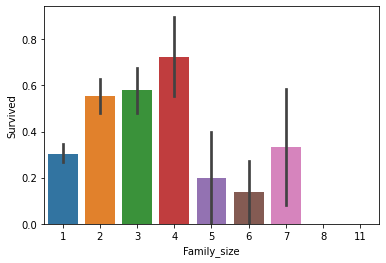

In [28]:
sns.barplot(x='Family_size', y='Survived', data=df)

<AxesSubplot:xlabel='Alone', ylabel='Survived'>

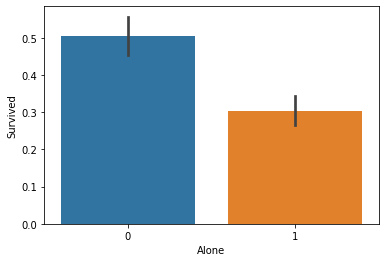

In [29]:
sns.barplot(x='Alone', y='Survived', data=df)

In [30]:
df['Family_label'] = 0
df.loc[((df['Family_size'].isin([5,6,7])) | (df['Family_size'] == 1)), 'Family_label'] = 1
df.loc[(df['Family_size'].isin([2,3,4])), 'Family_label'] = 2

In [31]:
df[df['Family_size'].isin([8, 11])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Acronym,Family_size,Alone,Family_label
59,60,0.0,3,"Goodwin, Master. William Frederick",male,11.000000,5,2,CA 2144,46.90,NaN,S,Master,8,0,0
71,72,0.0,3,"Goodwin, Miss. Lillian Amy",female,16.000000,5,2,CA 2144,46.90,NaN,S,Miss,8,0,0
159,160,0.0,3,"Sage, Master. Thomas Henry",male,5.482642,8,2,CA. 2343,69.55,NaN,S,Master,11,0,0
180,181,0.0,3,"Sage, Miss. Constance Gladys",female,21.795236,8,2,CA. 2343,69.55,NaN,S,Miss,11,0,0
201,202,0.0,3,"Sage, Mr. Frederick",male,32.252151,8,2,CA. 2343,69.55,NaN,S,Mr,11,0,0
324,325,0.0,3,"Sage, Mr. George John Jr",male,32.252151,8,2,CA. 2343,69.55,NaN,S,Mr,11,0,0
386,387,0.0,3,"Goodwin, Master. Sidney Leonard",male,1.000000,5,2,CA 2144,46.90,NaN,S,Master,8,0,0
480,481,0.0,3,"Goodwin, Master. Harold Victor",male,9.000000,5,2,CA 2144,46.90,NaN,S,Master,8,0,0
678,679,0.0,3,"Goodwin, Mrs. Frederick (Augusta Tyler)",female,43.000000,1,6,CA 2144,46.90,NaN,S,Mrs,8,0,0
683,684,0.0,3,"Goodwin, Mr. Charles Edward",male,14.000000,5,2,CA 2144,46.90,NaN,S,Mr,8,0,0


<AxesSubplot:xlabel='Family_label', ylabel='Survived'>

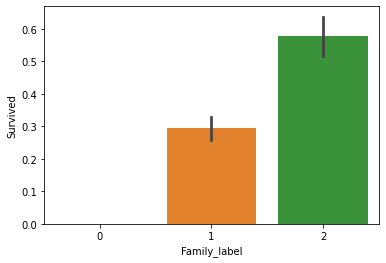

In [32]:
sns.barplot(x='Family_label', y='Survived', data=df)

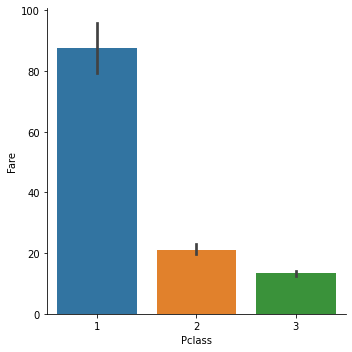

In [33]:
sns.catplot(x='Pclass', y='Fare', data=df, kind='bar')

In [34]:
df[df['Fare'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Acronym,Family_size,Alone,Family_label
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Mr,1,1,1


In [35]:
df['Fare'].fillna(df[(df['Pclass']==3) & (df['Sex']=='male') & (df['Embarked']=='S')]['Fare'].median(), inplace=True)

In [36]:
df['Cabin'].fillna('Unknown', inplace=True)
df['Cabin_label'] = df['Cabin'].str.get(0)

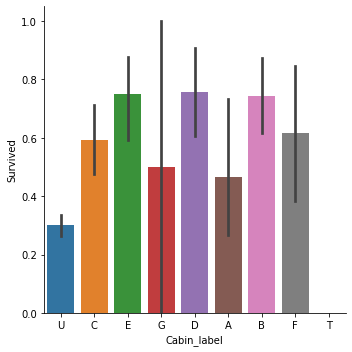

In [37]:
sns.catplot(x='Cabin_label', y='Survived', data=df, kind='bar')

In [38]:
ticket_counter = dict(df['Ticket'].value_counts())
df['Ticket_group'] = df['Ticket'].map(ticket_counter)

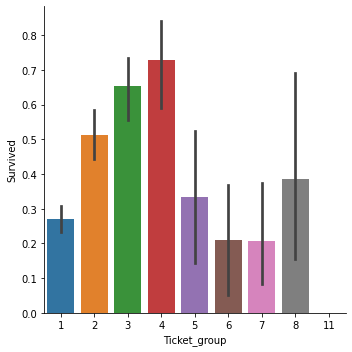

In [39]:
sns.catplot(x='Ticket_group', y='Survived', data=df, kind='bar')

In [40]:
df['Ticket_label'] = 0
df.loc[df['Ticket_group'].isin([1,5,6,7,8]), 'Ticket_label'] = 1
df.loc[df['Ticket_group'].isin([2,3,4]), 'Ticket_label'] = 2

In [41]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Acronym,Family_size,Alone,Family_label,Cabin_label,Ticket_group,Ticket_label
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,Unknown,S,Mr,2,0,2,U,1,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,Mrs,2,0,2,C,2,2
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,Unknown,S,Miss,1,1,1,U,1,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,Mrs,2,0,2,C,2,2
4,5,0.0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,Unknown,S,Mr,1,1,1,U,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,32.252151,0,0,A.5. 3236,8.0500,Unknown,S,Mr,1,1,1,U,1,1
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C105,C,Rare,1,1,1,C,3,2
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,Unknown,S,Mr,1,1,1,U,1,1
1307,1308,NaN,3,"Ware, Mr. Frederick",male,32.252151,0,0,359309,8.0500,Unknown,S,Mr,1,1,1,U,1,1


In [42]:
train_df = df[df['Survived'].notnull()].drop('Survived', axis = 1).reset_index(drop=True)
test_df = df[df['Survived'].isnull()].drop('Survived', axis = 1).reset_index(drop=True)

In [43]:
train_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Acronym,Family_size,Alone,Family_label,Cabin_label,Ticket_group,Ticket_label
0,1,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,Unknown,S,Mr,2,0,2,U,1,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,Mrs,2,0,2,C,2,2
2,3,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,Unknown,S,Miss,1,1,1,U,1,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,Mrs,2,0,2,C,2,2
4,5,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,Unknown,S,Mr,1,1,1,U,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,Unknown,S,Rare,1,1,1,U,1,1
887,888,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S,Miss,1,1,1,B,1,1
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,21.795236,1,2,W./C. 6607,23.4500,Unknown,S,Miss,4,0,2,U,4,2
889,890,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C,Mr,1,1,1,C,1,1


In [44]:
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Acronym,Family_size,Alone,Family_label,Cabin_label,Ticket_group,Ticket_label
0,892,3,"Kelly, Mr. James",male,34.500000,0,0,330911,7.8292,Unknown,Q,Mr,1,1,1,U,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000000,1,0,363272,7.0000,Unknown,S,Mrs,2,0,2,U,1,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.000000,0,0,240276,9.6875,Unknown,Q,Mr,1,1,1,U,1,1
3,895,3,"Wirz, Mr. Albert",male,27.000000,0,0,315154,8.6625,Unknown,S,Mr,1,1,1,U,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000000,1,1,3101298,12.2875,Unknown,S,Mrs,3,0,2,U,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,32.252151,0,0,A.5. 3236,8.0500,Unknown,S,Mr,1,1,1,U,1,1
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C105,C,Rare,1,1,1,C,3,2
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,Unknown,S,Mr,1,1,1,U,1,1
416,1308,3,"Ware, Mr. Frederick",male,32.252151,0,0,359309,8.0500,Unknown,S,Mr,1,1,1,U,1,1


In [45]:
KBinsDiscretizer.get_feature_names_out = (lambda self, names=None: self.feature_names_in_)

In [46]:
transformer = make_column_transformer(
    (KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform'), ['Age']),
    (KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile'), ['Fare']),
    (OneHotEncoder(drop='if_binary', handle_unknown='ignore'), ['Pclass', 'Sex', 'Embarked', 'Acronym', 'Family_label', 'Cabin_label', 'Ticket_label']),
    remainder='drop',
    n_jobs=-1)

In [47]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   891 non-null    int64  
 1   Pclass        891 non-null    int64  
 2   Name          891 non-null    object 
 3   Sex           891 non-null    object 
 4   Age           891 non-null    float64
 5   SibSp         891 non-null    int64  
 6   Parch         891 non-null    int64  
 7   Ticket        891 non-null    object 
 8   Fare          891 non-null    float64
 9   Cabin         891 non-null    object 
 10  Embarked      891 non-null    object 
 11  Acronym       891 non-null    object 
 12  Family_size   891 non-null    int64  
 13  Alone         891 non-null    int64  
 14  Family_label  891 non-null    int64  
 15  Cabin_label   891 non-null    object 
 16  Ticket_group  891 non-null    int64  
 17  Ticket_label  891 non-null    int64  
dtypes: float64(2), int64(9), objec

In [48]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   418 non-null    int64  
 1   Pclass        418 non-null    int64  
 2   Name          418 non-null    object 
 3   Sex           418 non-null    object 
 4   Age           418 non-null    float64
 5   SibSp         418 non-null    int64  
 6   Parch         418 non-null    int64  
 7   Ticket        418 non-null    object 
 8   Fare          418 non-null    float64
 9   Cabin         418 non-null    object 
 10  Embarked      418 non-null    object 
 11  Acronym       418 non-null    object 
 12  Family_size   418 non-null    int64  
 13  Alone         418 non-null    int64  
 14  Family_label  418 non-null    int64  
 15  Cabin_label   418 non-null    object 
 16  Ticket_group  418 non-null    int64  
 17  Ticket_label  418 non-null    int64  
dtypes: float64(2), int64(9), objec

In [49]:
rfc = RandomForestClassifier(random_state=17)

In [50]:
pipe_model = make_pipeline(transformer, rfc)

In [51]:
pipe_model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'randomforestclassifier', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__kbinsdiscretizer-1', 'columntransformer__kbinsdiscretizer-2', 'columntransformer__onehotencoder', 'columntransformer__kbinsdiscretizer-1__dtype', 'columntransformer__kbinsdiscretizer-1__encode', 'columntransformer__kbinsdiscretizer-1__n_bins', 'columntransformer__kbinsdiscretizer-1__strategy', 'columntransformer__kbinsdiscretizer-2__dtype', 'columntransformer__kbinsdiscretizer-2__encode', 'columntransformer__kbinsdiscretizer-2__n_bins', 'columntransformer__kbinsdiscretizer-2__strategy', 'columntransformer__onehotencoder__categories', 'columntransformer__onehotencoder__drop', 'columntransformer__onehotencoder__dtype', 'columntrans

In [52]:
parameters = {}
parameters['randomforestclassifier__max_depth'] = [i for i in range(2, 10, 2)]
parameters['randomforestclassifier__min_samples_split'] = [i for i in range(2, 11)]
parameters['randomforestclassifier__min_samples_leaf'] = [i for i in range(1, 11)]

In [53]:
gccv = GridSearchCV(pipe_model, parameters, cv=5,  scoring = 'accuracy', n_jobs=-1)

In [54]:
gccv.fit(train_df, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in colu

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('kbinsdiscretizer-1',
                                                                         KBinsDiscretizer(encode='ordinal',
                                                                                          strategy='uniform'),
                                                                         ['Age']),
                                                                        ('kbinsdiscretizer-2',
                                                                         KBinsDiscretizer(encode='ordinal',
                                                                                          n_bins=4),
                                                                         ['Fare']),
                                                                  

In [55]:
gccv.best_params_

{'randomforestclassifier__max_depth': 8,
 'randomforestclassifier__min_samples_leaf': 4,
 'randomforestclassifier__min_samples_split': 9}

In [56]:
gccv.best_score_

0.8383842822170611

In [57]:
gccv.score(train_df, y_train)

0.8552188552188552

In [58]:
predictions = gccv.predict(test_df)

In [59]:
output = pd.DataFrame({'PassengerId': pass_id_test, 'Survived': predictions})
output.to_csv('submission.csv', index=False)

In [60]:
output

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
